In [1]:
import os
import math
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.cpu_matcher import FlannMatcher

import scipy as sp
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist

%pylab inline
figsize(8,8)

%load_ext line_profiler

CUDA Disabled
Populating the interactive namespace from numpy and matplotlib


In [2]:
a = get_path('AS15-M-0295_SML.png')
b = get_path('AS15-M-0296_SML.png')

adjacency = {a:[b],
            b:[a]}

cg = CandidateGraph.from_adjacency(adjacency)
cg.extract_features(method='vlfeat')
cg.match_features()
cg.symmetry_checks()
cg.ratio_checks()
cg.compute_homographies()

Step 1: Identify, via the initially cleaned matched set, where the likley middle of the overlapping images is.  The paper seems to indicate that the initial points ($p_{1}, q_{1}$) can be approximate.  Computing the median of the overlap is pretty fast.

Step 2: Couple the images. At 0.5 degree increments, test for the angle of rotation looking for the maximum correlation.

/Users/jlaura/miniconda3/envs/autocnet/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/jlaura/miniconda3/envs/autocnet/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


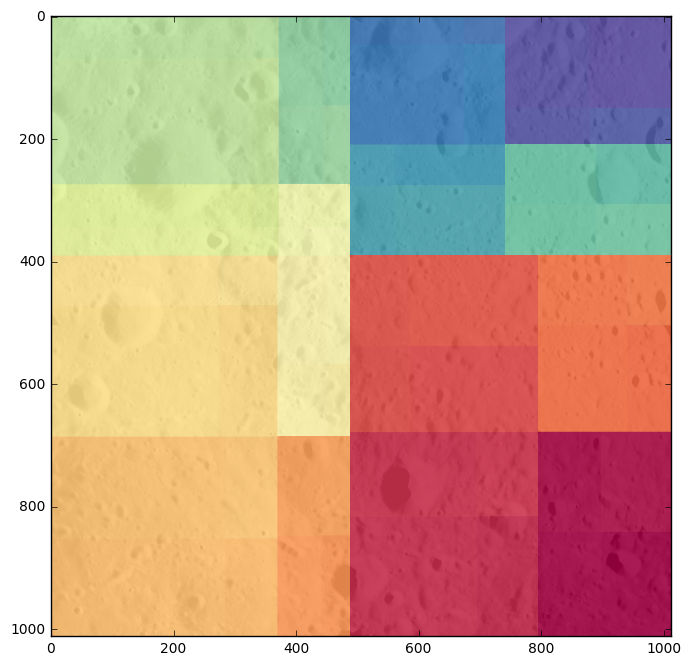

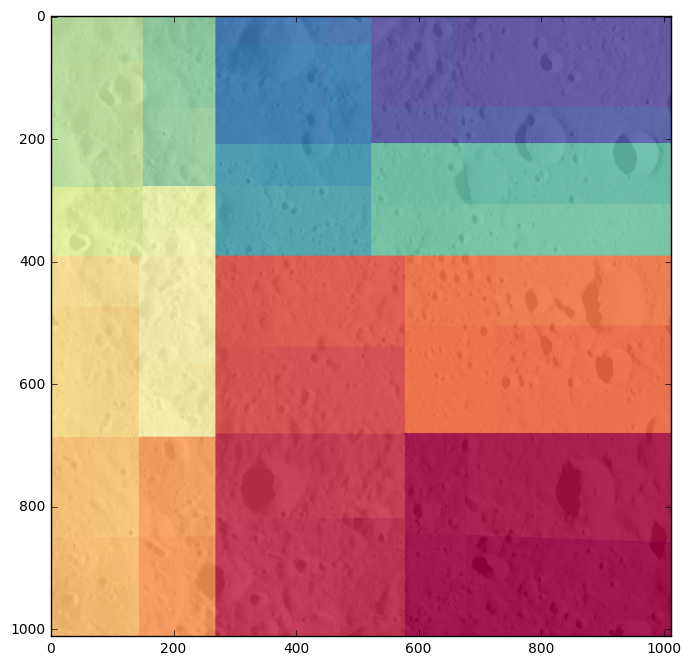

In [4]:
def cart2polar(x, y):
    theta = np.arctan2(y, x)
    return theta

def index_coords(data, origin=None):
    """Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def reproject_image_into_polar(data, origin=None):
    """Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    theta = cart2polar(x, y)
    theta[theta < 0] += 2 * np.pi
    return theta

def coupled_decomposition(sdata, ddata, sorigin=(), dorigin=(), M=4, sub_skp=None):
    """
    Apply coupled decomposition to two 2d images=.

    sdata : ndarray
            (n,m) array of values to decompose

    ddata : ndarray
            (j,k) array of values to decompose

    sorigin : tuple
              in the form (x,y)

    dorigin : tuple
              in the form (x,y)

    """
    
    RADIAL_SIZE = 720
    RADIAL_STEP = 2 * np.pi / RADIAL_SIZE
    THETAS = np.round(np.arange(0, 2 * np.pi, RADIAL_STEP), 5)

    soriginx, soriginy = sorigin
    doriginx, doriginy = dorigin

    # Create membership arrays for each input image
    smembership = np.ones(sdata.shape)
    dmembership = np.ones(ddata.shape)

    # Project the image into a polar coordinate system centered on p_{1}
    stheta = reproject_image_into_polar(sdata, origin=(int(soriginx), int(soriginy)))
    dtheta = reproject_image_into_polar(ddata, origin=(int(doriginx), int(doriginy)))

    # Compute the mean profiles for each radial slice
    smean = np.empty(RADIAL_SIZE)
    dmean = np.empty(RADIAL_SIZE)
    for i, t in enumerate(THETAS):
        # The way this method words, it is possible to get nan values in some of the steps as this is discrete
        smean[i] = np.mean(sdata[(t <= stheta) & (stheta <= t + RADIAL_STEP)])
        dmean[i] = np.mean(ddata[(t <= dtheta) & (dtheta <= t + RADIAL_STEP)])

    # Rotate the second image around the origin and compute the correlation coeff. for each 0.5 degree rotation.
    maxp = -1
    maxidx = 0
    for j in range(RADIAL_SIZE):
        dsearch = np.concatenate((dmean[j:], dmean[:j]))
        r, p = pearsonr(smean, dsearch)
        if r >= maxp:
            maxp = r
            maxidx = j

    # Maximum correlation (theta) defines the angle of rotation for the destination image
    theta = THETAS[maxidx]

    if theta <= np.pi:
        lam = theta
    else:
        lam = 2 * np.pi - theta

    # Classify the sub-images based on the decomposition size (M) and theta
    breaks = np.linspace(0, 2 * np.pi, M + 1)
    for i, t in enumerate(breaks[:-1]):
        smembership[(t <= stheta) & ( stheta <= breaks[i+1])] = i

    for i, t in enumerate(breaks[:-1]):
        # Handle the boundary crossers
        start_theta = t + theta
        stop_theta = breaks[i + 1] + theta

        if stop_theta > 2 * np.pi:
            stop_theta -= 2 * np.pi
        if start_theta > 2 * np.pi:
            start_theta -= 2 * np.pi

        if start_theta > stop_theta:
            # Handles the case where theta is a negative rotation
            dmembership[(start_theta <= dtheta) & (dtheta <= 2 * np.pi)] = i
            dmembership[(0 <= dtheta) & (dtheta <= stop_theta + lam)] = i
            dmembership[(start_theta <= dtheta) & (dtheta <= stop_theta)] = i
        else:
            # Handles the standard case without boundary crossers
            dmembership[(start_theta <= dtheta) & (dtheta <= stop_theta)] = i

    return smembership, dmembership
    
#def dec(cg):
snode = 0
dnode = 1
buf_dist = 3

# Grab the original image arrays
sdata = cg.node[snode].get_array()
ddata = cg.node[dnode].get_array()

ssize = sdata.shape
dsize = ddata.shape

# Grab all the available candidate keypoints
skp = cg.node[snode].get_keypoints()
dkp = cg.node[dnode].get_keypoints()

# Set up the membership arrays
smembership = np.zeros(sdata.shape, dtype=np.int16)
dmembership = np.zeros(ddata.shape, dtype=np.int16)
smembership[:] = -1
dmembership[:] = -1
pcounter = 0

def func(group):
    ratio = 0.8
    res = [False] * len(group)
    if len(res) == 1:
        return [single]
    if group.iloc[0] < group.iloc[1] * ratio:
        res[0] = True
    return res

# FLANN Matcher
fl= FlannMatcher()
maxiteration = 3
size = 18
for k in range(maxiteration):
    partitions = np.unique(smembership)
    for p in partitions:
        sy_part, sx_part = np.where(smembership == p)
        dy_part, dx_part = np.where(dmembership == p)

        # Get the source extent
        minsy = np.min(sy_part)
        maxsy = np.max(sy_part) + 1
        minsx = np.min(sx_part)
        maxsx = np.max(sx_part) + 1

        # Get the destination extent
        mindy = np.min(dy_part)
        maxdy = np.max(dy_part) + 1
        mindx = np.min(dx_part)
        maxdx = np.max(dx_part) + 1

        # Clip the sub image from the full images
        asub = sdata[minsy:maxsy, minsx:maxsx]
        bsub = ddata[mindy:maxdy, mindx:maxdx]

        # Utilize the FLANN matcher to find a match to approximate a center
        fl.add(cg.node[dnode].descriptors, cg.node[dnode].node_id)
        fl.train()

        scounter = 0
        decompose = False
        while True:
            sub_skp = skp.query('x >= {} and x <= {} and y >= {} and y <= {}'.format(minsx, maxsx, minsy, maxsy))
            # Check the size to ensure a valid return
            if len(sub_skp) == 0:
                break # No valid keypoints in this (sub)image
            if size > len(sub_skp):
                size = len(sub_skp)
            candidate_idx = np.random.choice(sub_skp.index, size=size, replace=False)
            candidates = cg.node[snode].descriptors[candidate_idx]
            matches = fl.query(candidates, cg.node[snode].node_id, k=3, index=candidate_idx)

            # Apply Lowe's ratio test to try to find a 'good' starting point
            mask = matches.groupby('source_idx')['distance'].transform(func).astype('bool')
            candidate_matches = matches[mask]
            match_idx = candidate_matches['source_idx']

            # Extract those matches that pass the ratio check
            sub_skp = skp.iloc[match_idx]

            # Check that valid points remain
            if len(sub_skp) == 0:
                break

            # Locate the candidate closest to the middle of all of the matches
            smx, smy = sub_skp[['x', 'y']].mean()
            mid = np.array([[smx, smy]])
            dists = cdist(mid, sub_skp[['x', 'y']])
            closest = sub_skp.iloc[np.argmin(dists)]
            closest_idx = closest.name
            soriginx, soriginy = closest[['x', 'y']]

            # Grab the corresponding point in the destination
            q = candidate_matches.query('source_idx == {}'.format(closest.name))
            dest_idx = q['destination_idx'].iat[0]
            doriginx = dkp.at[dest_idx, 'x']
            doriginy = dkp.at[dest_idx, 'y']

            if mindy + buf_dist <= doriginy <= maxdy - buf_dist\
             and mindx + 3 <= doriginx <= maxdx - 3:
                # Point is good to split on
                decompose = True
                break
            else:
                scounter += 1
                if scounter >= maxiteration:
                    break

        # Clear the Flann matcher for reuse
        fl.clear()

        # Check that the identified match falls within the (sub)image
        # This catches most bad matches that have passed the ratio check
        if not (buf_dist <= doriginx - mindx <= bsub.shape[1] - buf_dist) or not\
               (buf_dist <= doriginy - mindy <= bsub.shape[0] - buf_dist):
               decompose = False

        if decompose:
            # Apply coupled decomposition, shifting the origin to the sub-image
            s_submembership, d_submembership = coupled_decomposition(asub, bsub,
                                                                 sorigin=(soriginx - minsx, soriginy - minsy),
                                                                 dorigin=(doriginx - mindx, doriginy - mindy))

            # Shift the returned membership counters to a set of unique numbers
            s_submembership += pcounter
            d_submembership += pcounter

            # And assign membership
            smembership[minsy:maxsy,
                        minsx:maxsx] = s_submembership
            dmembership[mindy:maxdy,
                        mindx:maxdx] = d_submembership
            pcounter += 4




        pcounter += 4

#Visualize for a sanity check
imshow(sdata, cmap='gray')
imshow(smembership, alpha=0.9, cmap='Spectral')
show()

imshow(ddata, cmap='gray')
imshow(dmembership, alpha=0.9, cmap='Spectral')
show()

In [13]:
%lprun -f coupled_decomposition dec(cg)

/Users/jlaura/miniconda3/envs/autocnet/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/jlaura/miniconda3/envs/autocnet/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


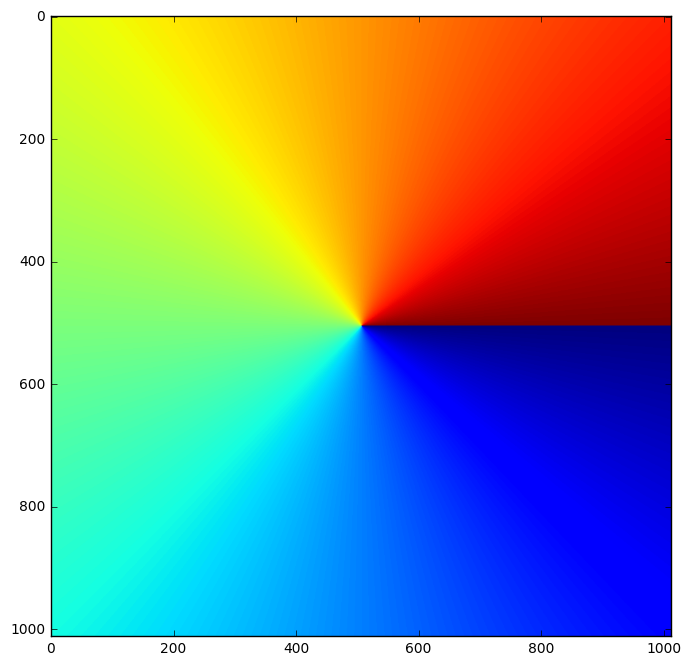

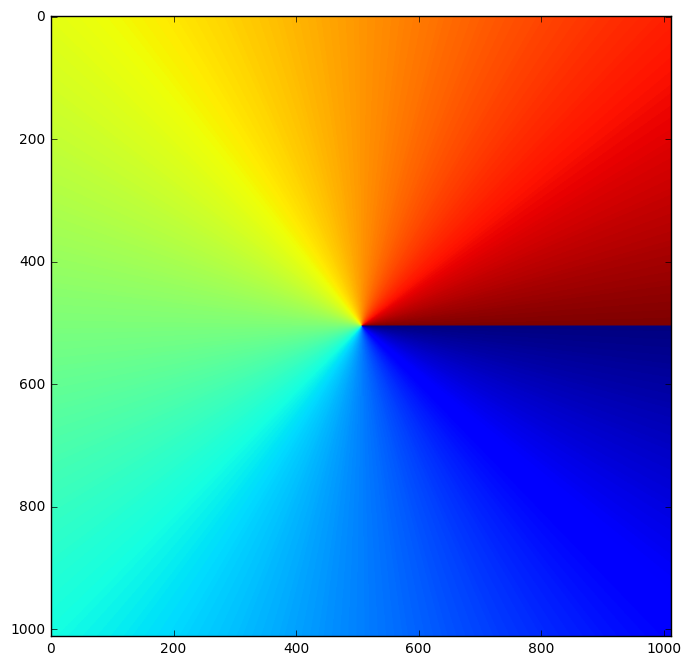

In [28]:
RADIAL_SIZE = 720
RADIAL_STEP = 2 * np.pi / RADIAL_SIZE
THETAS = np.round(np.arange(0, 2 * np.pi, RADIAL_STEP), 5)

sdata = cg.node[0].get_array()
stheta = reproject_image_into_polar(sdata, origin=(int(506), int(506)))

imshow(stheta)
show()

s = np.searchsorted(THETAS, stheta, side='left')
imshow(s)
show()


In [22]:
sdata.shape

(1012, 1012)

M = The number of cells to decompose.  M = 4


In [ ]:
2 * np.pi

In [ ]:
x[0:]

In [ ]:
np.concatenate((x[1:], x[:1]))

In [ ]:
2 * np.pi

In [ ]:
from scipy.spatial import Voronoi

In [ ]:
x = np.random.random((10,2))

In [ ]:
x

In [ ]:
vor = Voronoi(x)

In [ ]:
dir(vor)

In [ ]:
vor.ridge_points

In [ ]:
vor.ridge_vertices